# Optimising User Retention via A/B Testing & Predictive Modelling

## Introduction

### The Scenario
Cookie Cats is a popular mobile puzzle game where players progress through levels To monetize and control pacing, the developers use "gates" that require players to wait or make a purchase to continue. The company ran an A/B test to see if moving the first gate from Level 30 to Level 40 would improve user retention.

### The Problem Statement
Does delaying the first gate (moving it to Level 40) lead to a higher percentage of players returning to the game one day (Day-1) and seven days (Day-7) after installation?

### The Dataset

"Rounds and Retention (Cookie Cats)" Provided by Kaggle

The Dataset contains the columns:

In [13]:
# user_id:               id of player

# version:               game design version

# sum_gamerounds:        number of rounds played

# retention_1:           indicating if a user returned on 1st day after signing up

# retention_7:           indicating if a user returned on 7th day after signing up

### The Hypothesis

Null Hypothesis ($H_0$): There is no difference in retention between Gate 30 and Gate 40 ($Ret_{30} = Ret_{40}$).

Alternative Hypothesis ($H_1$): There is a significant difference in retention between the two gates ($Ret_{30} \neq Ret_{40}$)

## Dataset check + EDA

### Environment Setup & Data Acquisition

In [49]:
# @title
%pip install pandas numpy matplotlib seaborn scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_

In [50]:
# 1. Load the dataset

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/cookie_cats_cleaned.csv")

# 2. Inspect the first few rows
print("Dataset Head:")
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Head:
   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True


### Exploratory Data Analysis (EDA)

In [51]:
# 1. Check for missing values and data types
print("Data Info:")
print(df.info())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None


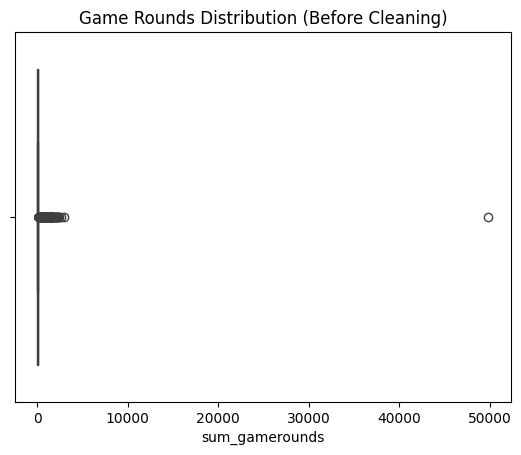

In [52]:
# 2. View Data
sns.boxplot(x=df['sum_gamerounds'])
plt.title('Game Rounds Distribution (Before Cleaning)')
plt.show()

There is a clear outlier shown by the box plot. Mobile game data often has 'whales' or bots that skew the mean.

In [53]:
# 3. Sanitize Data

df = df[df['sum_gamerounds'] < 40000]

# Verify the outlier is gone
print(f"New maximum rounds: {df['sum_gamerounds'].max()}")

New maximum rounds: 2961


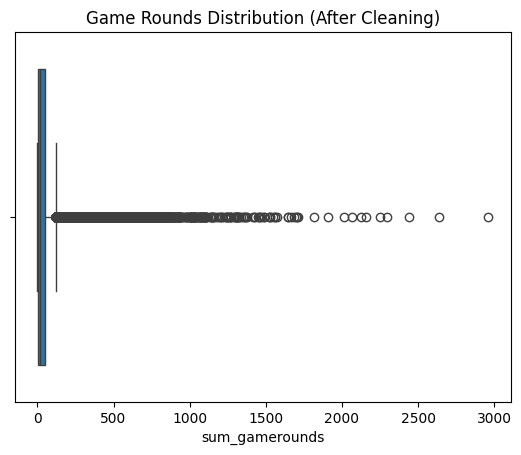

In [54]:
sns.boxplot(x=df['sum_gamerounds'])
plt.title('Game Rounds Distribution (After Cleaning)')
plt.show()

In [55]:
print(f"Cleaned Dataset Shape: {df.shape}")

Cleaned Dataset Shape: (90188, 5)


In [56]:
# 4. Analysing Retention

retention_by_version = df.groupby('version')[['retention_1', 'retention_7']].mean()

formatted_retention = retention_by_version.map(lambda x: f"{x:.2%}")

print("Retention Rates by Version:")
print(formatted_retention)

Retention Rates by Version:
        retention_1 retention_7
version                        
gate_30      44.82%      19.02%
gate_40      44.23%      18.20%


In [57]:
# 5. Analyze Engagement (Game Rounds)

group_engagement = df.groupby('version')['sum_gamerounds'].agg(['mean', 'median', 'std'])

print("\nEngagement Stats (Game Rounds) by Group:")
print(fomatted_engagement)



Engagement Stats (Game Rounds) by Group:
          mean median     std
version                      
gate_30  51.34  17.00  102.06
gate_40  51.30  16.00  103.29


Our EDA shows that whilst engagement rates are similar, there is shown to be a reduction of retention when the gate is moved back to Level 40. One explaination is that moving the gate further away makes players get bored before they reach the "natural break" that the gate provides, leading to early churn.

We must investigate this further to prove whether this is a true conclusion.

## Statistical Hypothesis Testing

I will use Bootstrapping (resampling with replacement) to simulate the game 10,000 times. This tells us how confident we are that moving the gate to Level 40 actually hurts retention.

The Method (Bootstrapping):

- Create a loop that resamples your data.

- In each iteration, calculate the retention for both groups.

- Plot the distribution of the difference in retention.

Conclusion: If 95% or more of the distribution shows that Level 30 has higher retention, you have "statistically significant" proof that moving the gate was a bad idea.

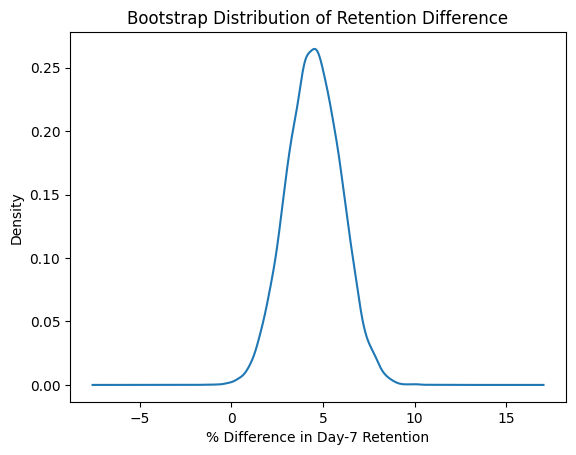


Probability that Level 30 has higher 7-day retention: 99.90%


In [60]:
# 1. Create a list of bootstrap means for both groups
boot_1d = []
iterations = 10000

for i in range(iterations):
    # Resample the data and calculate the mean for each version
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean)

# 2. Transform the list into a DataFrame
boot_1d = pd.DataFrame(boot_1d)

# 3.Calculate the % difference between the two groups
boot_1d['diff'] = (boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100

# 4. Plot the bootstrap difference
ax = boot_1d['diff'].plot.kde()
ax.set_xlabel("% Difference in Day-7 Retention")
ax.set_title("Bootstrap Distribution of Retention Difference")
plt.show()

# 5. Calculate the probability that Gate 30 has higher retention
prob = (boot_1d['diff'] > 0).mean()
print(f"\nProbability that Level 30 has higher 7-day retention: {prob:.2%}")


With a probability well exceeding the standard 95% confidence threshold ($p < 0.05$), we reject the Null Hypothesis. There is strong evidence that moving the gate to Level 40 negatively impacts long-term player retention.

## Predictive Modeling (Churn Prediction)

I will use the data to see if we can identify a "churner" (someone who doesn't return) based on their early behavior.

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score

# 1. Prepare the Data (Feature Encoding)
df['version_binary'] = df['version'].map({'gate_30': 0, 'gate_40': 1})

# 2. Define Features (X) and Target (y)
X = df[['version_binary', 'sum_gamerounds']]
y = df['retention_7']

# 3. Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Initialize and Train the Model
model = LogisticRegression()
model.fit(X_train, y_train)

# 5. Make Predictions and Evaluate
y_pred = model.predict(X_test)

print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"F1-Score:{f1_score(y_test, y_pred):.2%}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 87.14%
F1-Score:55.42%

Detailed Classification Report:
              precision    recall  f1-score   support

       False       0.88      0.97      0.92     14652
        True       0.79      0.43      0.55      3386

    accuracy                           0.87     18038
   macro avg       0.84      0.70      0.74     18038
weighted avg       0.86      0.87      0.86     18038



Model Evaluation Note: While the model achieves a high Accuracy (87.14%), the F1-Score (55.42%) reveals that the model struggles to identify retained players due to class imbalance.

In [64]:
# Check which feature mattered most
## Exponential of coefficient to 2sf is used for clear readability
importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': np.exp(model.coef_[0])})
importance['Coefficient'] = importance['Coefficient'].round(2)
print(importance)

          Feature  Coefficient
0  version_binary         0.94
1  sum_gamerounds         1.02


Moving the gate from Level 30 to Level 40 decreases a player's odds of returning by 6% (1.00 - 0.94 = 0.06).

Whereas, for every extra round played, the player is 2% more likely to be retained.

## Conclusions

While the Bootstrapping proved that Gate 30 is statistically better, our Logistic Regression coefficients show that 'total rounds played' is actually the primary driver of retention. This suggests that instead of just moving gates, we should also focus on early-game features that increase the number of rounds played in the first hour.